In [2]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
def get_columns_and_types(df):
    print('Types detected:')
    print(df.dtypes.unique())
    return {
        'int': [i for i in df.dtypes if type in [int, np.int64]],
        'float': [i for i in df.dtypes if type in [float, np.float64]],
        'object': [i for i in df.dtypes if type == 'object'],
    }


# Boston Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/boston?resource=download

In [25]:
boston_listings = pd.read_csv('./data/airbnb_boston/listings.csv', index_col='id')
boston_calendar = pd.read_csv('./data/airbnb_boston/calendar.csv')
boston_reviews = pd.read_csv('./data/airbnb_boston/reviews.csv')

In [26]:
boston_listing_col_types = get_columns_and_types(boston_listings)

Types detected:
[dtype('O') dtype('int64') dtype('float64')]


In [27]:
boston_calendar_col_types = get_columns_and_types(boston_calendar)

Types detected:
[dtype('int64') dtype('O')]


In [28]:
boston_review_col_types = get_columns_and_types(boston_reviews)

Types detected:
[dtype('int64') dtype('O')]


In [83]:
# convert price column to a float, assuming format of $#.#
boston_calendar.price = [float(i.replace('$', '').replace(',', '')) if type(i) is str else i for i in boston_calendar.price]

# concert date to a datetime object
boston_calendar.date = [pd.Timestamp(i) if type(i) is str else i for i in boston_calendar.date]

# add a month, year columns for seasonality analysis
boston_calendar['month'] = [i.month for i in boston_calendar.date]
boston_calendar['year'] = [i.year for i in boston_calendar.date]

In [89]:
boston_calendar.head()

,listing_id,date,available,price,year,month
0,12147973,2017-09-05,f,NaN,2017,9
1,12147973,2017-09-04,f,NaN,2017,9
2,12147973,2017-09-03,f,NaN,2017,9
3,12147973,2017-09-02,f,NaN,2017,9
4,12147973,2017-09-01,f,NaN,2017,9


<Axes: xlabel='month', ylabel='price'>

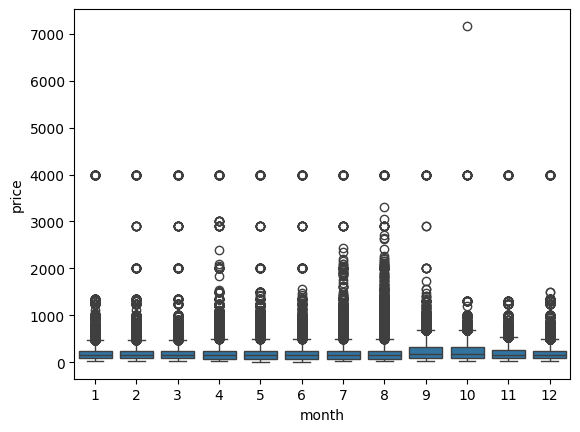

In [92]:
sns.boxplot(
    data=boston_calendar.dropna(),
    x='month',
    y='price',
)

# Seattle Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/seattle/data

In [7]:
seattle_listings = pd.read_csv('./data/airbnb_seattle/listings.csv', index_col='id')

In [21]:
seattle_col_types = get_columns_and_types(seattle_listings)

Types detected:
[dtype('O') dtype('int64') dtype('float64')]


# Stackoverflow Survey Dataset
https://www.kaggle.com/datasets/stackoverflow/so-survey-2017